In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


## Carregando os dados

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score , RandomizedSearchCV , KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#paleta de cores
iris = '#5D3FD3'
indigo = '#3F00FF'
royal_blue = '#4169E1'
light_steel_blue = '#B0C4DE'
slate_gray = '#B0C4DE'
light_slate_gray = '#778899'
medium_green = '#00FA9A'
jade = '#00A36C'

plt.style.use('fivethirtyeight')

In [4]:
X_full = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
X_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')

In [5]:
X_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
X_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# Split

In [7]:
X = X_full.drop(columns = ['SalePrice'])

y = X_full['SalePrice']

# Analise Exploratória

In [8]:
X_full.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [9]:
X_full.describe(exclude = np.number)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


`Neighborhood` é a feature CATEGÓRICA com maior número de valores únicos, 25

In [10]:
max_cat = X_full['Neighborhood'].nunique() #25

### Agregando colunas

In [11]:
#Agrupando features numéricas
numeric_features  = [cls for cls in X.columns if X[cls].dtype == 'float64' or X[cls].dtype =='int64']
print('>>numeric_features:', numeric_features ,
      len(numeric_features))


#Agrupando features categoricas
cat_features = [cls for cls in X.columns if X[cls].dtypes == 'object' and X[cls].nunique()<=max_cat]
print('\n>>cat_features:', cat_features ,
      len(cat_features))

#agurpando features categoricas orginais
ordinal_features = ['ExterQual','ExterCond','BsmtQual','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC']
print(f'\n>>>ordianl features: {ordinal_features} - {len(ordinal_features)}')

#agrupando features categorias nominais
nominal_features = list(set(cat_features) - set(ordinal_features))
print(f'\n>>>nominal_features:{nominal_features} - {len(nominal_features)}')

>>numeric_features: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'] 36

>>cat_features: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 

A fim de facilitar as transformações de dados, a célula acima agrupa as `features` em algumas categorias:
* `numeric_features` são as variáveis numéricas
* `cat_features` são as variáveis catégoricas, não numéricas
    * `ordinal_features` são variáveis categóricas que possuem alguma ordem ou grau. Tal como encontramos em `PoolQC` em que nos é indicado o nível de qualidade da piscina da casa:
        *     Excelente
        *     bom
        *     mediano
        *     ruim
        *     sem piscina
    * `nominal_features` indicam um número qualidativo, ao contrario das ordinais estas variáveis não possuem ordem,
       

Text(0.5, 1.0, 'Frequência Qualidade da piscina nas casas')

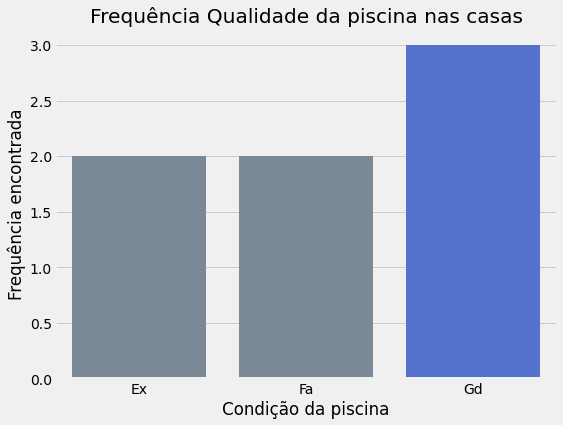

In [12]:
# variável categporica ordinal
plt.figure(figsize=(8,6))
sns.countplot(data = X, x= 'PoolQC', orient='v',palette=[light_slate_gray,light_slate_gray,royal_blue])
plt.ylabel('Frequência encontrada')
plt.xlabel('Condição da piscina')
plt.title('Frequência Qualidade da piscina nas casas')

In [13]:
cols_null =  [[col,X[col].isnull().sum()] for col in numeric_features if X[col].isnull().sum() > 0]

pd_null = pd.DataFrame(cols_null)
pd_null.rename(columns={0: 'numeric_features',1:'null_values'},inplace=True)
pd_null.sort_values(by=['null_values'],ascending=False,inplace=True)
pd_null.head()

,numeric_features,null_values
0,LotFrontage,259
2,GarageYrBlt,81
1,MasVnrArea,8


Text(0.5, 0, 'Variaveis numéricas')

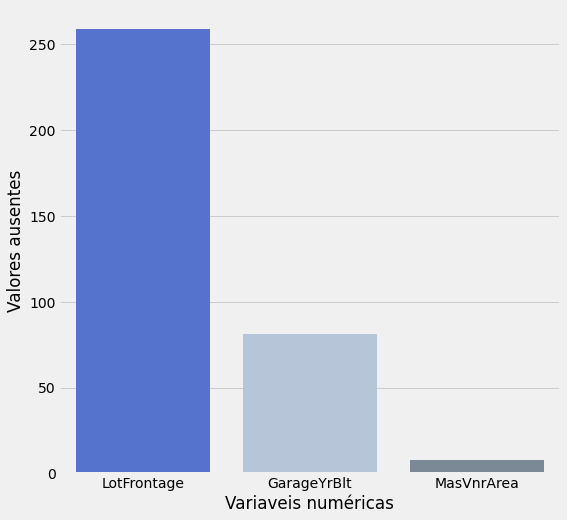

In [14]:
# Tamanho da figura
fig2, ax = plt.subplots(1, 1, figsize=(8,8))
sns.barplot(data = pd_null,
            x = pd_null['numeric_features'],
            y = pd_null['null_values'],
           palette=[royal_blue,light_steel_blue,light_slate_gray])
plt.ylabel('Valores ausentes')
plt.xlabel('Variaveis numéricas')

Das variáveis numéricas, apenas:
* LotFrontage
* GarageYrBlt
* MasVnrArea

possuem valores ausentes


In [15]:
cols_null =  [[col,X[col].isnull().sum()] for col in cat_features if X[col].isnull().sum() > 0]

pd_null = pd.DataFrame(cols_null)
pd_null.rename(columns={0: 'cat_features',1:'null_values'},inplace=True)
pd_null.sort_values(by=['null_values'],ascending=False,inplace=True)
pd_null.head(30)

,cat_features,null_values
13,PoolQC,1453
15,MiscFeature,1406
0,Alley,1369
14,Fence,1179
8,FireplaceQu,690
9,GarageType,81
10,GarageFinish,81
11,GarageQual,81
12,GarageCond,81
4,BsmtExposure,38


Text(0.5, 0, 'Variaveis categóricas')

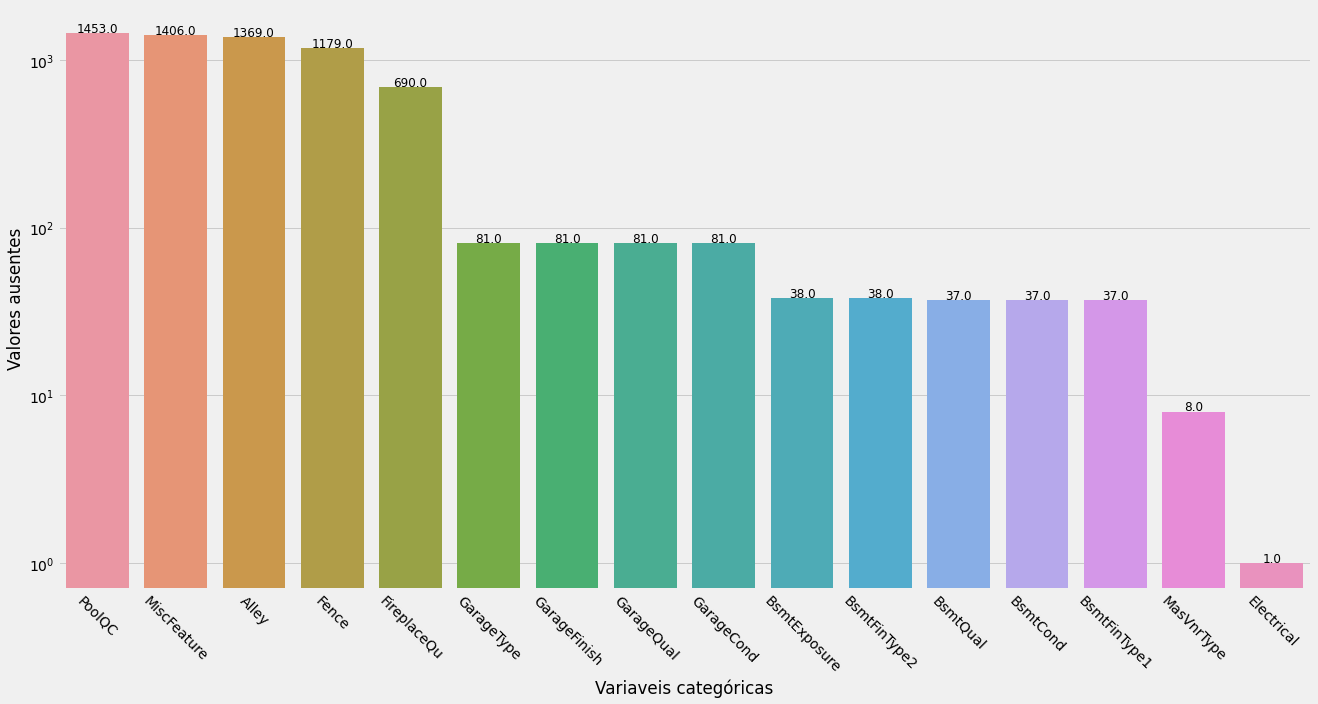

In [16]:
# Tamanho da figura
fig2, ax = plt.subplots(1, 1, figsize=(20,10))
plot = sns.barplot(data = pd_null,
            x = pd_null['cat_features'],
            y = pd_null['null_values'],
            orient='v'
           )

for i in plot.patches:
    plot.annotate(i.get_height(),
                  (i.get_x() + i.get_width() / 2, i.get_height()),
                  ha='center',
                  va='baseline',
                  fontsize=12,
                  color='black',
                  xytext=(0, 1),
                  textcoords='offset points')

plt.xticks(rotation = -45)
plt.yscale('log')
plt.ylabel('Valores ausentes')
plt.xlabel('Variaveis categóricas')

## Data correlation matrix


In [17]:
# Data correlation matrix
corr_metrics = X.corr()
corr_metrics.style.background_gradient()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
MSSubClass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407
LotFrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450
LotArea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261
OverallQual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347
OverallCond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950
YearBuilt,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618
YearRemodAdd,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743
MasVnrArea,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201
BsmtFinSF1,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359
BsmtFinSF2,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,-0.209294,0.104810,0.097117,-0.099260,0.014807,-0.009640,0.158678,0.070948,-0.076444,-0.032148,-0.015728,-0.040751,-0.035227,0.046921,-0.088011,-0.038264,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706


Ao contrário das numéricas, as categóricas possuem uma maior quantidade de valores ausentes

# Processamento de dados e modelagem

Após a separação dos tipos de variáveis do dataset, criaremos as etapas de transformação de dados

## Imputação e codificação

Para as variáveis numéricas, substituiremos o valores `NAN` por uma medida de centralidade, neste caso a ***mediana***

In [18]:
numerical_transformer = SimpleImputer(strategy='median')

## Pipeline e transformação

In [19]:

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), #MODA
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), #MODA
    ('ordinal', OrdinalEncoder(handle_unknown='ignore'))
])




Aqui está o motivo pelo quais separamos os dados anteriormente. De forma a facilitar a codificação de dados categóricos nominais e ordinais, utilizamos dois métodos

* Foi-se optado pelo OneHotEnconde para as variáveis nominais, haja vista variabilidade das informações
* No entanto, Ordinal Encoder foi pensando na ordenação natural das variáveis ordinais

Além disso, optamos por substituir também usando uma medida descritiva dos dados, a MODA



In [20]:
preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numerical_transformer, numeric_features),
                    ('cat_nom', nominal_transformer, nominal_features),
                    ('ord_nom', ordinal_transformer, ordinal_features)
                ])


Em seguida, `ColumnTransformer()` é o responsável por aplicar cada transformador criado à sua determinada coluna de dados

### Pipeline

In [21]:
pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('minmaxscaler', MinMaxScaler()),
        ('stdscaler',  StandardScaler()),
        ('regressor', RandomForestRegressor(n_estimators=200,random_state=0, criterion='mse',max_depth=10))
    
])

Dada as transformações, foi necessário aplicar outras técnicas ao conjunto. `MinMaxScaler` e `StandardScaler` reduzem a escala proporcionalmente dos valores e assim como normalizam estatisticamente os mesmos

O modelo de regressão escolhido foi o `Random Forest` devido a sua robustês e simplicidade na otimização dos hiperparâmetros

Por fim, a `Pipeline` reune todos os processos e os aplica sequencialmente 

## Treinamento e Predição

Separando os dados de treino e validação

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=3)

Treinando o modelo

In [23]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath...
                                                 

Ótimo, agora vamos as previsões nos dados de validação

In [24]:
val_predictions = pipe.predict(X_val)

In [25]:
mean_squared_error(y_val, val_predictions, squared=False)

30328.323447929793

In [26]:
mean_absolute_error(y_val, val_predictions)

17161.689484236347

Vamos facilitar a visualização destes dados 

In [27]:
pd.DataFrame({'y_val': y_val,
            'val_pred': val_predictions,
             'abs_err': abs(val_predictions-y_val)}).describe()

,y_val,val_pred,abs_err
count,292.000000,292.000000,292.000000
mean,178248.863014,178769.705244,17161.689484
std,70389.950788,66737.692096,25048.599924
min,55000.000000,80629.487083,71.854910
25%,128800.000000,133258.973818,4809.708160
50%,158500.000000,157204.258329,10620.058682
75%,202600.000000,207646.368098,21547.965368
max,466500.000000,450680.414375,290680.414375


### Predição no teste

In [28]:
test_predict= pipe.predict(X_test)

## Validando o modelo

In [29]:
scores = -1 * cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_absolute_error')

In [30]:
scores

array([17764.97816739, 17668.60301154, 17973.49148608, 16197.17534763,
       19172.01446991])

In [31]:
scores.mean()

17755.252496510635

In [32]:
scores.std()

947.6338817922363

# Arquivo de submissão

In [33]:
output = pd.DataFrame({'Id': X_test.index,
                      'SalePrice': test_predict})

output.set_index('Id', inplace=True)
output.to_csv('submission.csv')